In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib as mpl
import seaborn as sns
from datetime import datetime, timedelta
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import networkx as nx
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import LinearRegression
import re
import warnings
import os

warnings.filterwarnings('ignore')

mpl.rcParams['font.family'] = 'Malgun Gothic'
mpl.rcParams['axes.unicode_minus'] = False 



### 데이터 전처리
    1.날짜 관련 컬럼(date_added)을 datetime 객체로 변환하고, 변환 불가능한 값은 NaT로 처리.
    2.날짜 정보가 없는 행은 분석의 정확성을 위해 제거.
    3.'year_added', 'month_added', 'release_decade'와 같은 새로운 날짜 관련 컬럼을 생성.
    4. 결측치(NaN)를 'Unknown' 또는 빈 문자열로 대체하여 분석 오류를 방지.
    5. 'duration' 컬럼에서 숫자(duration_value)와 단위(duration_unit)를 분리.

In [2]:
def load_and_preprocess_netflix_data(csv_path='netflix_titles.csv'):
    try:
        df = pd.read_csv(csv_path)
        print(f"Original data shape: {df.shape}")
        
        # date_added 변환 및 NaT 처리
        df['date_added'] = pd.to_datetime(df['date_added'], errors='coerce')
        
        before_drop = len(df)
        df = df.dropna(subset=['date_added'])
        print(f"날짜 없는 행 {before_drop - len(df)}개 제거")
        
        df['year_added'] = df['date_added'].dt.year
        df['month_added'] = df['date_added'].dt.month
        df['release_decade'] = (df['release_year'] // 10) * 10
        
        df['country'] = df['country'].fillna('Unknown')
        df['director'] = df['director'].fillna('Unknown')
        df['cast'] = df['cast'].fillna('Unknown')
        df['rating'] = df['rating'].fillna('UNRATED')
        df['description'] = df['description'].fillna('')
        
        df['duration_value'] = df['duration'].apply(
            lambda x: int(re.findall(r'\d+', str(x))[0]) if pd.notna(x) and re.findall(r'\d+', str(x)) else np.nan
        )
        df['duration_unit'] = df['duration'].apply(
            lambda x: re.findall(r'[a-zA-Z]+', str(x))[0].strip() if pd.notna(x) and re.findall(r'[a-zA-Z]+', str(x)) else 'Unknown'
        )
        
        print(f"Preprocessing complete. Final data shape: {df.shape}")
        return df
        
    except FileNotFoundError:
        print(f"Error: The file {csv_path} was not found.")
        return None
    except Exception as e:
        print(f"Error occurred during data loading: {e}")
        return None


### 콘텐츠 전략 변화

In [3]:
def analyze_content_strategy_shift(df):
    try:
        # 연도별 콘텐츠 타입
        yearly_content = df.groupby(['year_added', 'type']).size().unstack(fill_value=0)
        yearly_content['total'] = yearly_content.sum(axis=1)
        yearly_content['movie_ratio'] = yearly_content['Movie'] / yearly_content['total']
        yearly_content['tv_ratio'] = yearly_content['TV Show'] / yearly_content['total']
        
        fig = make_subplots(
            rows=2, cols=2,
            subplot_titles=('연도별 콘텐츠 추가량', '콘텐츠 타입 비율 변화', 
                          '월별 콘텐츠 추가 패턴', '등급별 분포'),
            specs=[[{"secondary_y": False}, {"secondary_y": False}],
                   [{"secondary_y": False}, {"type": "domain"}]]
        )
        
        # 연도별 추가량
        fig.add_trace(
            go.Scatter(x=yearly_content.index, y=yearly_content['Movie'],
                      name='영화', line=dict(color='blue')), 
            row=1, col=1
        )
        fig.add_trace(
            go.Scatter(x=yearly_content.index, y=yearly_content['TV Show'],
                      name='TV 프로그램', line=dict(color='red')), 
            row=1, col=1
        )
        
        fig.add_trace(
            go.Scatter(x=yearly_content.index, y=yearly_content['tv_ratio'],
                      name='TV 프로그램 비율', line=dict(color='red', dash='dash')), 
            row=1, col=2
        )
        
        # 월별 패턴
        monthly_pattern = df.groupby('month_added').size()
        fig.add_trace(
            go.Bar(x=monthly_pattern.index, y=monthly_pattern.values,
                   name='월별 추가량', marker_color='green'), 
            row=2, col=1
        )
        
        # 등급별 분포
        rating_dist = df['rating'].value_counts().head(10) 
        fig.add_trace(
            go.Pie(labels=rating_dist.index, values=rating_dist.values, name='등급별 분포'), 
            row=2, col=2
        )
        
        fig.update_layout(height=800, title_text="Netflix 콘텐츠 전략 분석 대시보드")
        return fig, yearly_content
        
    except Exception as e:
        print(f"콘텐츠 전략 분석 중 오류: {e}")
        return None, None


### 글로벌 콘텐츠 분포 분석

In [4]:

def analyze_global_content_distribution(df):
    try:
        # 국가별 콘텐츠 수 계산
        country_counts = {}
        for countries in df['country'].dropna():
            for country in str(countries).split(', '):
                country = country.strip()
                if country and country != 'Unknown':
                    country_counts[country] = country_counts.get(country, 0) + 1
        
        if not country_counts:
            print("국가 데이터가 없습니다.")
            return None, None
        
        # 상위 15개 국가
        top_countries = sorted(country_counts.items(), key=lambda x: x[1], reverse=True)[:15]
        
        fig = make_subplots(
            rows=2, cols=2,
            subplot_titles=('국가별 콘텐츠 수', '미국 vs 기타 국가', 
                          '연도별 국가 다양성', '지역별 콘텐츠 타입'),
            specs=[[{"type": "bar"}, {"type": "domain"}],
                   [{"secondary_y": False}, {"type": "bar"}]]
        )
        
        # 국가별 콘텐츠 수
        countries, counts = zip(*top_countries)
        fig.add_trace(
            go.Bar(x=list(countries), y=list(counts), 
                   name='콘텐츠 수', marker_color='skyblue'), 
            row=1, col=1
        )
        
        # 미국 vs 기타
        us_count = country_counts.get('United States', 0)
        other_count = sum(country_counts.values()) - us_count
        fig.add_trace(
            go.Pie(labels=['미국', '기타 국가'], values=[us_count, other_count], 
                   name='지역별 비율'), 
            row=1, col=2
        )
        
        # 연도별 국가 다양성
        yearly_countries = df.groupby('year_added')['country'].apply(
            lambda x: len(set([c.strip() for countries in x.dropna() 
                             for c in str(countries).split(', ') if c.strip() != 'Unknown']))
        )
        fig.add_trace(
            go.Scatter(x=yearly_countries.index, y=yearly_countries.values,
                      name='연도별 국가 수', line=dict(color='orange')), 
            row=2, col=1
        )
        
        # 지역별 콘텐츠 타입
        top_5_countries = [c[0] for c in top_countries[:5]]
        movies_data = []
        tv_data = []
        
        for country in top_5_countries:
            country_data = df[df['country'].str.contains(country, na=False)]
            movie_count = len(country_data[country_data['type'] == 'Movie'])
            tv_count = len(country_data[country_data['type'] == 'TV Show'])
            movies_data.append(movie_count)
            tv_data.append(tv_count)
        
        fig.add_trace(
            go.Bar(x=top_5_countries, y=movies_data, name='영화', marker_color='blue'), 
            row=2, col=2
        )
        fig.add_trace(
            go.Bar(x=top_5_countries, y=tv_data, name='TV 프로그램', marker_color='red'), 
            row=2, col=2
        )
        
        fig.update_layout(height=800, title_text="Netflix 글로벌 콘텐츠 분포 분석", barmode='group')
        return fig, country_counts
        
    except Exception as e:
        print(f"Errors during global content distribution analysis: {e}")
        return None, None

### 배우-감독 네트워크 분석

In [5]:
def create_actor_director_network(df):
    try:
        G = nx.Graph()
        
        # 처리할 데이터 필터링 (Unknown 제외)
        valid_data = df[(df['cast'] != 'Unknown') & (df['director'] != 'Unknown')].head(100)  # 성능을 위해 100개만
        
        for _, row in valid_data.iterrows():
            directors = [d.strip() for d in str(row['director']).split(',')]
            actors = [a.strip() for a in str(row['cast']).split(',')]
            
            for director in directors:
                if director and director != 'Unknown':
                    if not G.has_node(director):
                        G.add_node(director, type='director')
                    
                    for actor in actors:
                        if actor and actor != 'Unknown':
                            if not G.has_node(actor):
                                G.add_node(actor, type='actor')
                            
                            if G.has_edge(director, actor):
                                G[director][actor]['weight'] += 1
                            else:
                                G.add_edge(director, actor, weight=1)
        
        # 연결되지 않은 노드 제거
        nodes_to_remove = [node for node, degree in G.degree() if degree == 0]
        G.remove_nodes_from(nodes_to_remove)
        
        if len(G.nodes()) == 0:
            print("네트워크 생성을 위한 유효한 데이터가 없습니다.")
            return None, None, None
        
        # 중심성
        degree_centrality = nx.degree_centrality(G)
        betweenness_centrality = nx.betweenness_centrality(G)
        
        top_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
        top_betweenness = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
    
        pos = nx.spring_layout(G, k=0.5, iterations=50)
        
        edge_x, edge_y = [], []
        for edge in G.edges():
            x0, y0 = pos[edge[0]]
            x1, y1 = pos[edge[1]]
            edge_x.extend([x0, x1, None])
            edge_y.extend([y0, y1, None])
        
        node_x, node_y, node_text, node_color, node_size = [], [], [], [], []
        for node in G.nodes():
            x, y = pos[node]
            node_x.append(x)
            node_y.append(y)
            node_text.append(f"{node}<br>연결 정도: {degree_centrality[node]:.3f}")
            node_color.append('red' if G.nodes[node].get('type') == 'director' else 'blue')
            node_size.append(5 + degree_centrality[node] * 50)
        
        fig = go.Figure()
        
        fig.add_trace(go.Scatter(
            x=edge_x, y=edge_y,
            line=dict(width=0.5, color='gray'),
            hoverinfo='none',
            mode='lines',
            name='연결'
        ))
        
        # 노드 추가
        fig.add_trace(go.Scatter(
            x=node_x, y=node_y,
            mode='markers',
            hoverinfo='text',
            text=node_text,
            marker=dict(size=node_size, color=node_color, 
                       line=dict(width=1, color='DarkSlateGrey')),
            name='인물'
        ))
        
        fig.update_layout(
            title="Netflix 배우-감독 네트워크 분석",
            showlegend=True,
            hovermode='closest',
            margin=dict(b=20, l=5, r=5, t=40),
            xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
            yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)
        )
        
        return fig, top_degree, top_betweenness
        
    except Exception as e:
        print(f"Errors during network analysis: {e}")
        return None, None, None

### 콘텐츠 유사도 분석

In [6]:
def content_similarity_analysis(df):
    try:
        # 텍스트 전처리
        descriptions = df['description'].fillna('')
        
        # TF-IDF 벡터화
        vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
        tfidf_matrix = vectorizer.fit_transform(descriptions)
        
        # 코사인 유사도 계산 
        sample_size = min(500, len(df))
        sample_indices = np.random.choice(len(df), sample_size, replace=False)
        cosine_sim = cosine_similarity(tfidf_matrix[sample_indices], tfidf_matrix[sample_indices])
        
        # 장르 추출
        genre_keywords = {
            '액션': ['action', 'fight', 'battle', 'adventure', 'thriller'],
            '코미디': ['comedy', 'funny', 'humor', 'laugh', 'hilarious'],
            '드라마': ['drama', 'emotional', 'family', 'life', 'story'],
            '로맨스': ['love', 'romance', 'relationship', 'romantic'],
            '공포': ['horror', 'scary', 'fear', 'haunted', 'terror'],
            '다큐멘터리': ['documentary', 'real', 'true', 'history'],
            'SF': ['sci-fi', 'science', 'future', 'space', 'technology'],
            '범죄': ['crime', 'criminal', 'police', 'detective', 'murder']
        }
        
        def extract_genre(description):
            description_lower = str(description).lower()
            for genre, keywords in genre_keywords.items():
                if any(keyword in description_lower for keyword in keywords):
                    return genre
            return '기타'
        
        df['extracted_genre'] = df['description'].apply(extract_genre)
        genre_dist = df['extracted_genre'].value_counts()
        
        def get_recommendations(title, df=df):
            try:
                matches = df[df['title'].str.contains(title, case=False, na=False)]
                if matches.empty:
                    return f"'{title}'Title not found."
                
                idx = matches.index[0]
                
                full_cosine_sim = cosine_similarity(tfidf_matrix[idx:idx+1], tfidf_matrix)
                sim_scores = list(enumerate(full_cosine_sim[0]))
                sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
                
                # 상위 5개 추천 (자기 자신 제외)
                sim_scores = sim_scores[1:6]
                content_indices = [i[0] for i in sim_scores]
                
                recommendations = df.iloc[content_indices][['title', 'type', 'extracted_genre', 'rating']].copy()
                recommendations['similarity_score'] = [score[1] for score in sim_scores]
                
                return recommendations
                
            except Exception as e:
                return f"Error making a recommendation: {e}"
    
        fig = make_subplots(
            rows=2, cols=2,
            subplot_titles=('장르별 콘텐츠 분포', '연도별 장르 트렌드', 
                          '장르별 평균 등급', '콘텐츠 유사도 히트맵'),
            specs=[[{"type": "bar"}, {"secondary_y": False}],
                   [{"type": "bar"}, {"type": "heatmap"}]]
        )
        
        # 장르별 분포
        fig.add_trace(
            go.Bar(x=genre_dist.index, y=genre_dist.values,
                   name='장르별 콘텐츠 수', marker_color='lightblue'), 
            row=1, col=1
        )
        
        # 연도별 장르 트렌드
        genre_yearly = df.groupby(['year_added', 'extracted_genre']).size().unstack(fill_value=0)
        top_genres = genre_dist.head(3).index  # 상위 3개 장르만
        
        for genre in top_genres:
            if genre in genre_yearly.columns:
                fig.add_trace(
                    go.Scatter(x=genre_yearly.index, y=genre_yearly[genre],
                              name=f'{genre} 트렌드', mode='lines+markers'), 
                    row=1, col=2
                )
        
        # 장르별 평균 등급
        rating_map = {
            'TV-G': 1, 'TV-Y': 1, 'TV-Y7': 1.5, 'TV-Y7-FV': 1.5,
            'TV-PG': 2, 'PG': 2, 'TV-14': 3, 'PG-13': 3,
            'TV-MA': 4, 'R': 4, 'NC-17': 5, 'UR': 2.5, 'NR': 2.5, 'UNRATED': 2.5
        }
        df['rating_numeric'] = df['rating'].map(rating_map).fillna(2.5)
        genre_rating = df.groupby('extracted_genre')['rating_numeric'].mean().sort_values(ascending=False)
        
        fig.add_trace(
            go.Bar(x=genre_rating.index, y=genre_rating.values,
                   name='평균 등급', marker_color='orange'), 
            row=2, col=1
        )
        
        # 유사도 히트맵
        sample_sim = cosine_sim[:10, :10]
        sample_df = df.iloc[sample_indices[:10]]
        sample_titles = [title[:20] + '...' if len(title) > 20 else title 
                        for title in sample_df['title'].tolist()]
        
        fig.add_trace(
            go.Heatmap(z=sample_sim, x=sample_titles, y=sample_titles,
                      colorscale='Viridis', name='유사도'), 
            row=2, col=2
        )
        
        fig.update_layout(height=900, title_text="Netflix 콘텐츠 유사도 및 장르 분석")
        return fig, get_recommendations, genre_dist
        
    except Exception as e:
        print(f"Errors during similarity analysis: {e}")
        return None, None, None



### 성장 모델링 및 예측 분석

In [ ]:
def growth_modeling_analysis(df):
    try:
        # if 'year_added' not in df.columns:
        #     df['year_added'] = df['date_added'].dt.year
            
        # # 월별 데이터 준비
        # monthly_data = df.groupby([df['date_added'].dt.year, df['date_added'].dt.month]).size().reset_index()
        # monthly_data.columns = ['year', 'month', 'count']
        # monthly_data['date'] = pd.to_datetime(monthly_data[['year', 'month']].assign(day=1))
        # monthly_data = monthly_data.sort_values('date')
        
        if not np.issubdtype(df['date_added'].dtype, np.datetime64):
            df['date_added'] = pd.to_datetime(df['date_added'], errors='coerce')
        
        # 연, 월 컬럼 생성
        df['year_added'] = df['date_added'].dt.year
        df['month_added'] = df['date_added'].dt.month

        # 월별 데이터 집계
        monthly_data = (
            df.groupby(['year_added', 'month_added'])
              .size()
              .reset_index(name='count')
        )

        # date 컬럼 생성 (year/month 컬럼 대신 year_added/month_added 사용!)
        monthly_data['date'] = pd.to_datetime({
            'year': monthly_data['year_added'],
            'month': monthly_data['month_added'],
            'day': [1] * len(monthly_data)
        })
        # 정렬
        monthly_data = monthly_data.sort_values('date').reset_index(drop=True)
        
        # 이동평균 계산
        monthly_data['ma_3'] = monthly_data['count'].rolling(window=3, min_periods=1).mean()
        monthly_data['ma_6'] = monthly_data['count'].rolling(window=6, min_periods=1).mean()
        
        # 연도별 성장률
        yearly_growth = df.groupby('year_added').size()
        yearly_growth_rate = yearly_growth.pct_change() * 100
        
        # TV Show 비율 변화
        yearly_type_ratio = df.groupby(['year_added', 'type']).size().unstack(fill_value=0)
        yearly_type_ratio['tv_ratio'] = yearly_type_ratio['TV Show'] / (
            yearly_type_ratio['Movie'] + yearly_type_ratio['TV Show']
        )
        
        # 예측 모델 (최근 5년 데이터 사용)
        recent_years = yearly_type_ratio.index[-5:]
        X = recent_years.values.reshape(-1, 1)
        y = yearly_type_ratio.loc[recent_years, 'tv_ratio'].values
        
        model = LinearRegression()
        model.fit(X, y)
        
        # 미래 예측
        future_years = np.array(range(yearly_type_ratio.index.max() + 1, 
                                    yearly_type_ratio.index.max() + 4)).reshape(-1, 1)
        future_tv_ratio = model.predict(future_years)
        future_tv_ratio = np.clip(future_tv_ratio, 0, 1)
        
        fig = make_subplots(
            rows=2, cols=2,
            subplot_titles=('월별 콘텐츠 추가 트렌드', '연도별 성장률', 
                          'TV 프로그램 비율 변화 및 예측', '국가별 성장 패턴'),
            specs=[[{"secondary_y": False}, {"secondary_y": False}],
                   [{"secondary_y": False}, {"secondary_y": False}]]
        )
        
        # 월별 트렌드
        fig.add_trace(
            go.Scatter(x=monthly_data['date'], y=monthly_data['count'],
                      name='월별 추가량', line=dict(color='blue')), 
            row=1, col=1
        )
        fig.add_trace(
            go.Scatter(x=monthly_data['date'], y=monthly_data['ma_6'],
                      name='6개월 이동평균', line=dict(color='red', dash='dash')), 
            row=1, col=1
        )
        
        # 연도별 성장률
        fig.add_trace(
            go.Bar(x=yearly_growth_rate.index, y=yearly_growth_rate.values,
                   name='연도별 성장률(%)', marker_color='green'), 
            row=1, col=2
        )
        
        # TV Show 비율 예측
        fig.add_trace(
            go.Scatter(x=yearly_type_ratio.index, y=yearly_type_ratio['tv_ratio'],
                      name='실제 TV 프로그램 비율', mode='lines+markers', 
                      line=dict(color='purple')), 
            row=2, col=1
        )
        fig.add_trace(
            go.Scatter(x=future_years.flatten(), y=future_tv_ratio,
                      name='예측 TV 프로그램 비율', mode='lines+markers',
                      line=dict(color='orange', dash='dash')), 
            row=2, col=1
        )
        
        # 국가별 성장 패턴 (상위 3개국)
        country_counts = {}
        for countries in df['country'].dropna():
            for country in str(countries).split(', '):
                country = country.strip()
                if country and country != 'Unknown':
                    country_counts[country] = country_counts.get(country, 0) + 1
        
        top_countries = sorted(country_counts.items(), key=lambda x: x[1], reverse=True)[:3]
        
        for country, _ in top_countries:
            country_yearly = df[df['country'].str.contains(country, na=False)].groupby('year_added').size()
            if not country_yearly.empty:
                fig.add_trace(
                    go.Scatter(x=country_yearly.index, y=country_yearly.values,
                              name=f'{country}', mode='lines+markers'), 
                    row=2, col=2
                )
        
        fig.update_layout(height=800, title_text="Netflix 성장 모델링 및 예측 분석")
        return fig, monthly_data, future_tv_ratio
            
    except Exception as e:
        print(f"성장 모델링 분석 오류: {e}")
        return None, None, None


Funnel, Cohort, Time Series 분석

In [8]:
df = load_and_preprocess_netflix_data('netflix_titles.csv')

df_clean = df.copy()
df_clean['date_added'] = pd.to_datetime(df_clean['date_added'])

Original data shape: (8807, 12)
날짜 없는 행 98개 제거
Preprocessing complete. Final data shape: (8709, 17)


In [10]:
total_content = len(df_clean)

funnel_data = {
    'stage': [], 
    'count': [], 
    'step_conversion_rate': [],   
    'cumulative_conversion_rate': [],  
    'drop_off_rate': []      
}

# 1단계: 전체 콘텐츠
funnel_data['stage'].append('1. 전체 콘텐츠')
funnel_data['count'].append(total_content)
funnel_data['step_conversion_rate'].append(100.0)
funnel_data['cumulative_conversion_rate'].append(100.0)
funnel_data['drop_off_rate'].append(0.0)

# 2단계: 등급 정보 보유
rated_content = len(df_clean[df_clean['rating'].notna() & (df_clean['rating'] != '')])
step_conv2 = rated_content / total_content * 100
cum_conv2 = rated_content / total_content * 100
funnel_data['stage'].append('2. 등급 정보 보유')
funnel_data['count'].append(rated_content)
funnel_data['step_conversion_rate'].append(step_conv2)
funnel_data['cumulative_conversion_rate'].append(cum_conv2)
funnel_data['drop_off_rate'].append(100 - step_conv2)

# 3단계: 설명 정보 보유
described_content = len(df_clean[df_clean['description'].notna() & (df_clean['description'] != '')])
step_conv3 = described_content / rated_content * 100 if rated_content > 0 else 0
cum_conv3 = described_content / total_content * 100
funnel_data['stage'].append('3. 설명 정보 보유')
funnel_data['count'].append(described_content)
funnel_data['step_conversion_rate'].append(step_conv3)
funnel_data['cumulative_conversion_rate'].append(cum_conv3)
funnel_data['drop_off_rate'].append(100 - step_conv3)

# 4단계: 출연진 정보 보유
cast_content = len(df_clean[df_clean['cast'].notna() & (df_clean['cast'] != '')])
step_conv4 = cast_content / described_content * 100 if described_content > 0 else 0
cum_conv4 = cast_content / total_content * 100
funnel_data['stage'].append('4. 출연진 정보 보유')
funnel_data['count'].append(cast_content)
funnel_data['step_conversion_rate'].append(step_conv4)
funnel_data['cumulative_conversion_rate'].append(cum_conv4)
funnel_data['drop_off_rate'].append(100 - step_conv4)

funnel_df = pd.DataFrame(funnel_data)

퍼널 분석 완료 - 최종 단계 누적 전환율: 100.0%


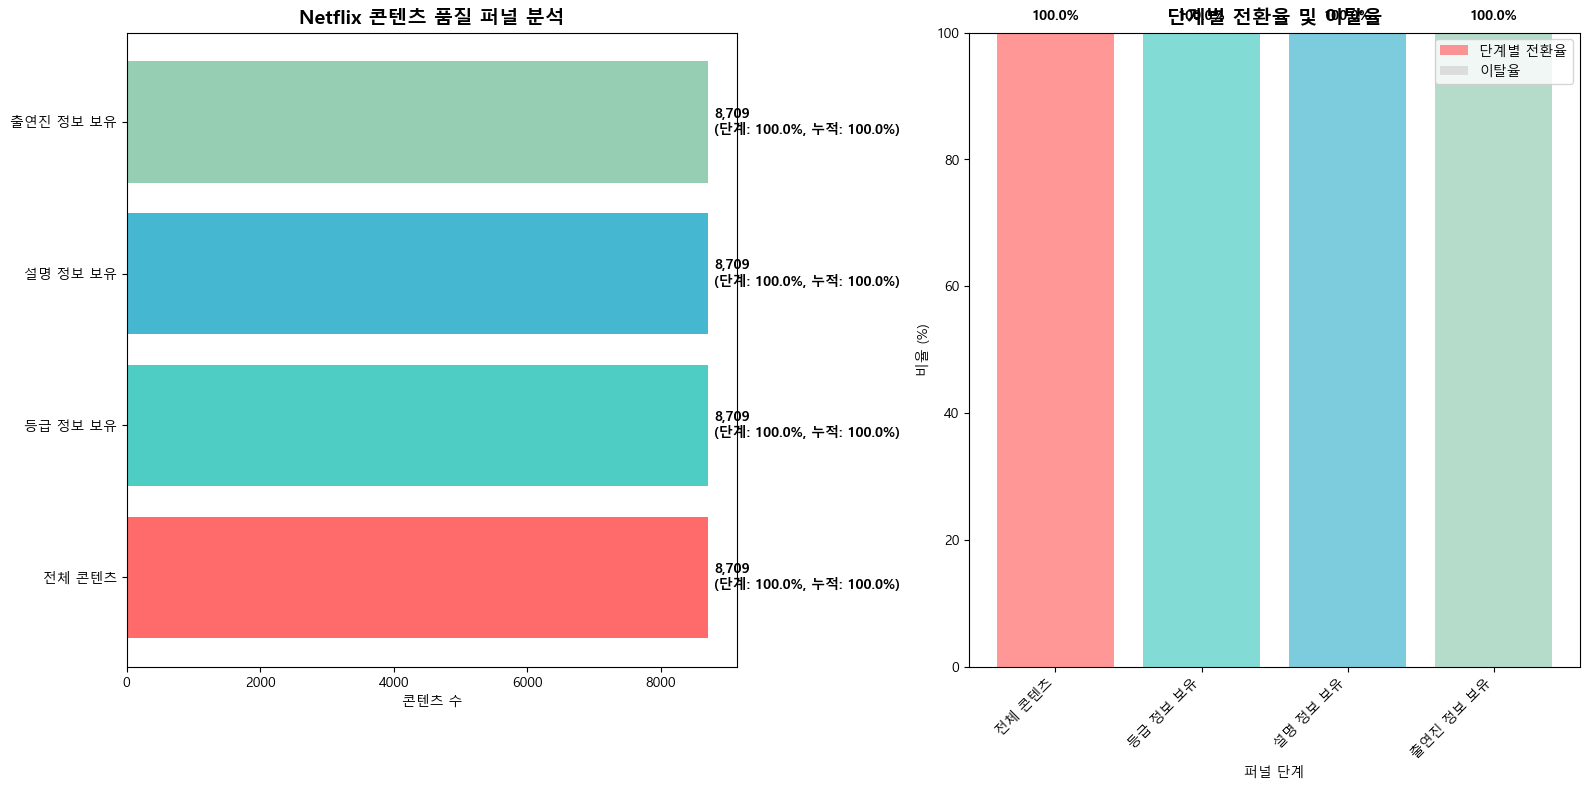

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

stages = funnel_df['stage'].str.replace(r'^\d+\.\s*', '', regex=True)
counts = funnel_df['count']
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']

# 단계별 콘텐츠 수 + 누적 전환율
bars = ax1.barh(stages, counts, color=colors)
ax1.set_xlabel('콘텐츠 수')
ax1.set_title('Netflix 콘텐츠 품질 퍼널 분석', fontsize=14, fontweight='bold')

for i, (bar, count, step_rate, cum_rate) in enumerate(zip(
        bars, counts, funnel_df['step_conversion_rate'], funnel_df['cumulative_conversion_rate'])):
    ax1.text(bar.get_width() + max(counts)*0.01, bar.get_y() + bar.get_height()/2, 
             f'{count:,}\n(단계: {step_rate:.1f}%, 누적: {cum_rate:.1f}%)', 
             ha='left', va='center', fontweight='bold')

# 단계별 전환율 & 이탈율
x = np.arange(len(stages))
ax2.bar(x, funnel_df['step_conversion_rate'], color=colors, alpha=0.7, label='단계별 전환율')
ax2.bar(x, funnel_df['drop_off_rate'], bottom=funnel_df['step_conversion_rate'], 
        color='lightgray', alpha=0.7, label='이탈율')

ax2.set_xlabel('퍼널 단계')
ax2.set_ylabel('비율 (%)')
ax2.set_title('단계별 전환율 및 이탈율', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(stages, rotation=45, ha='right')
ax2.legend()
ax2.set_ylim(0, 100)

for i, rate in enumerate(funnel_df['step_conversion_rate']):
    ax2.text(i, rate + 2, f'{rate:.1f}%', ha='center', fontweight='bold')

plt.tight_layout()
print(f"퍼널 분석 완료 - 최종 단계 누적 전환율: {cum_conv4:.1f}%")

In [12]:
funnel_df[['stage','count','step_conversion_rate','cumulative_conversion_rate']]

,stage,count,step_conversion_rate,cumulative_conversion_rate
0,1. 전체 콘텐츠,8709,100.0,100.0
1,2. 등급 정보 보유,8709,100.0,100.0
2,3. 설명 정보 보유,8709,100.0,100.0
3,4. 출연진 정보 보유,8709,100.0,100.0


---------------------------------------------------------------------------------------------------------------------

시계열 분석 - 최고 활동 월: 7월, 최저 활동 월: 2월


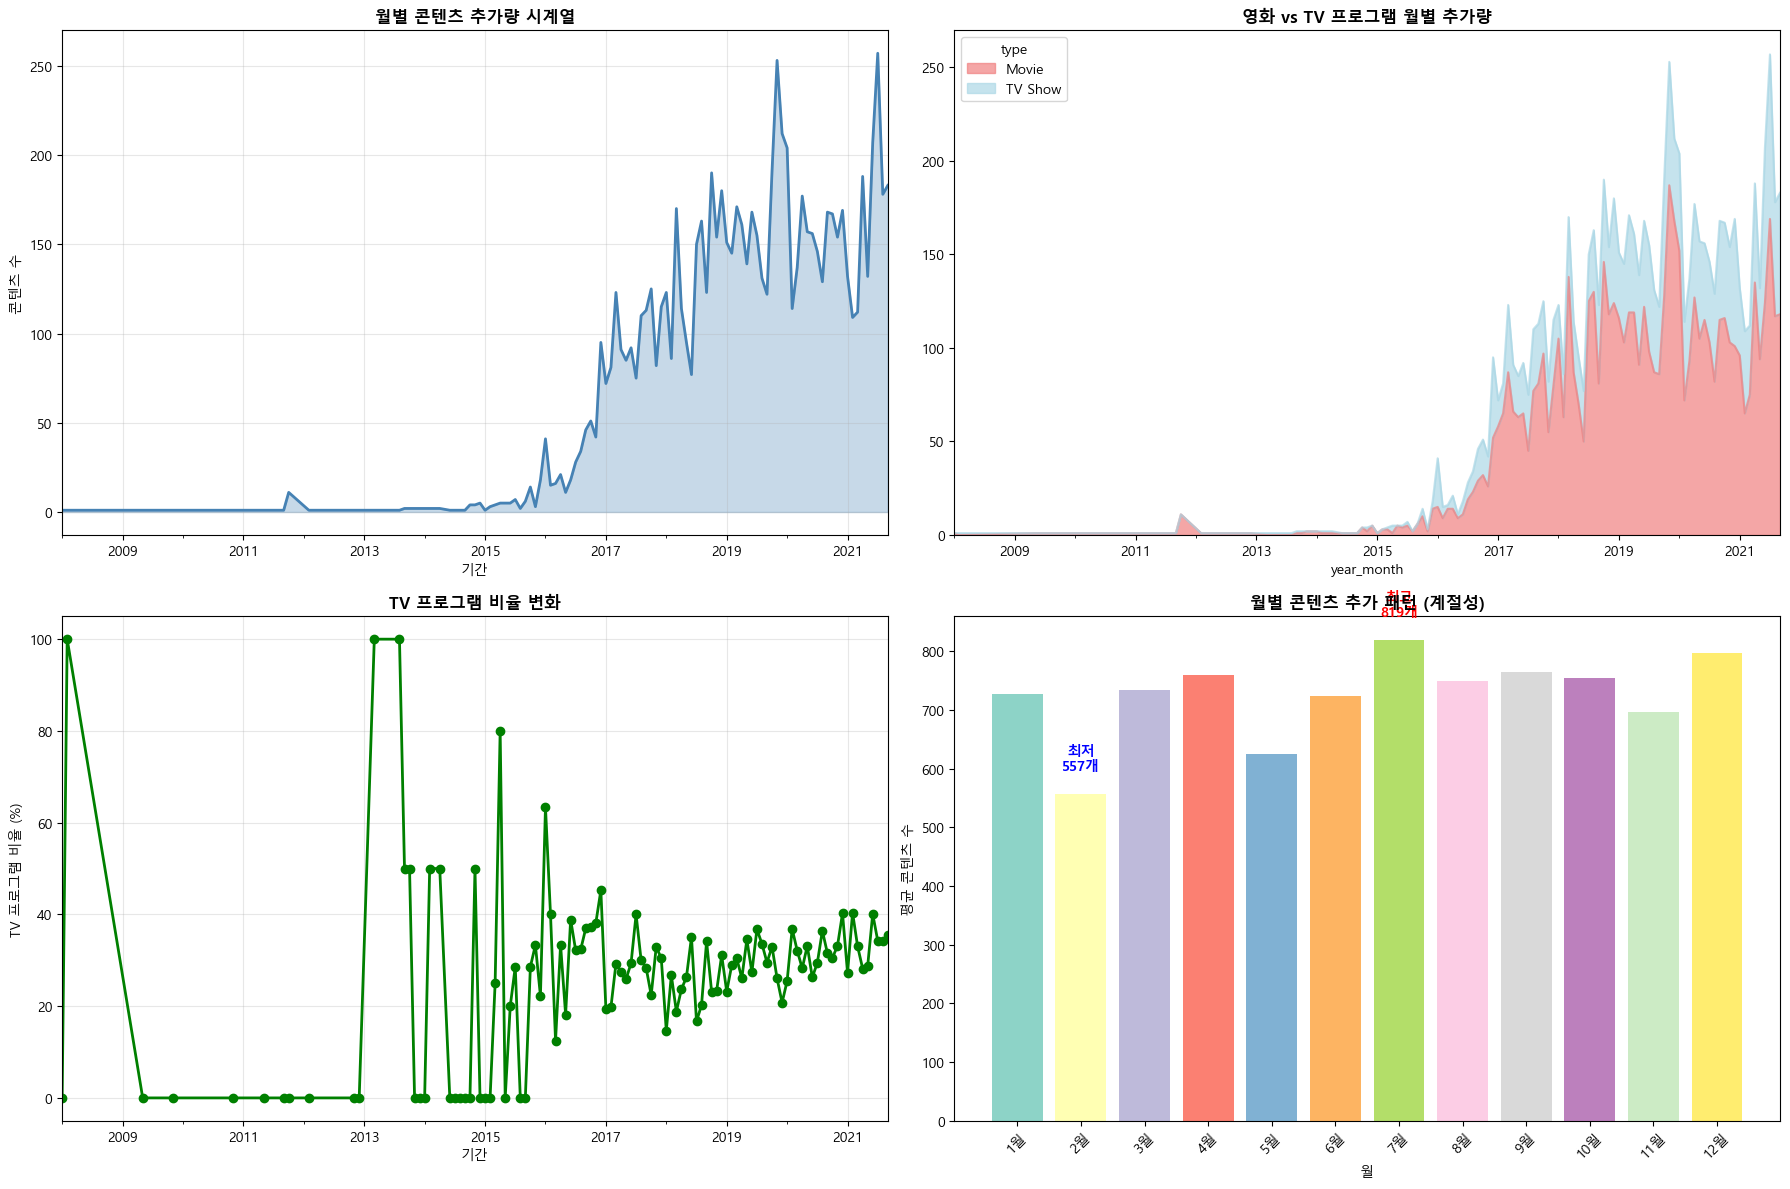

In [13]:
df_time = df_clean[df_clean['date_added'].notna()].copy()
df_time['year_month'] = df_time['date_added'].dt.to_period('M')

monthly_stats = df_time.groupby(['year_month', 'type']).size().unstack(fill_value=0)
monthly_total = monthly_stats.sum(axis=1)

fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# 월별 전체 콘텐츠 추가량
ax1 = axes[0, 0]
monthly_total.plot(ax=ax1, color='steelblue', linewidth=2)
ax1.fill_between(monthly_total.index.astype(str), monthly_total.values, alpha=0.3, color='steelblue')
ax1.set_title('월별 콘텐츠 추가량 시계열', fontsize=12, fontweight='bold')
ax1.set_xlabel('기간')
ax1.set_ylabel('콘텐츠 수')
ax1.grid(True, alpha=0.3)

# 영화 vs TV 프로그램
ax2 = axes[0, 1]
if 'Movie' in monthly_stats.columns and 'TV Show' in monthly_stats.columns:
    monthly_stats.plot(kind='area', stacked=True, ax=ax2, color=['lightcoral', 'lightblue'], alpha=0.7)
ax2.set_title('영화 vs TV 프로그램 월별 추가량', fontsize=12, fontweight='bold')

# TV 프로그램 비율 변화
ax3 = axes[1, 0]
tv_ratio = monthly_stats.get('TV Show', pd.Series(0, index=monthly_stats.index)) / monthly_total * 100
tv_ratio.plot(ax=ax3, color='green', linewidth=2, marker='o')
ax3.set_title('TV 프로그램 비율 변화', fontsize=12, fontweight='bold')
ax3.set_xlabel('기간')
ax3.set_ylabel('TV 프로그램 비율 (%)')
ax3.grid(True, alpha=0.3)

# 계절성 분석
ax4 = axes[1, 1]
df_time['month'] = df_time['date_added'].dt.month
seasonal_pattern = df_time.groupby('month').size()
bars = ax4.bar(seasonal_pattern.index, seasonal_pattern.values, color=plt.cm.Set3(np.linspace(0, 1, 12)))
ax4.set_title('월별 콘텐츠 추가 패턴 (계절성)', fontsize=12, fontweight='bold')
ax4.set_xlabel('월')
ax4.set_ylabel('평균 콘텐츠 수')
ax4.set_xticks(range(1, 13))
ax4.set_xticklabels([f'{i}월' for i in range(1, 13)], rotation=45)

max_month = seasonal_pattern.idxmax()
min_month = seasonal_pattern.idxmin()
ax4.text(max_month, seasonal_pattern[max_month] + seasonal_pattern.max() * 0.05, f'최고\n{seasonal_pattern[max_month]}개', ha='center', fontweight='bold', color='red')
ax4.text(min_month, seasonal_pattern[min_month] + seasonal_pattern.max() * 0.05, f'최저\n{seasonal_pattern[min_month]}개', ha='center', fontweight='bold', color='blue')

plt.tight_layout()

print(f"시계열 분석 - 최고 활동 월: {max_month}월, 최저 활동 월: {min_month}월")

--------------------------------------------------------------------------------------------------------------------------

코호트 분석
장르 트렌드 (상승: +, 하락: -): {'Dramas': np.float64(-2.4120281913335404), 'International Movies': np.float64(0.18199401777604418), 'Comedies': np.float64(0.7949483562502687), 'International TV Shows': np.float64(1.0978852359506155), 'Documentaries': np.float64(0.15050827341780001), 'Action & Adventure': np.float64(0.8545149943961226), 'Children & Family Movies': np.float64(-0.17065823038659536), 'Independent Movies': np.float64(-1.1146349111700093), 'Crime TV Shows': np.float64(0.1749917011619246), "Kids' TV": np.float64(0.4424787539373681)}


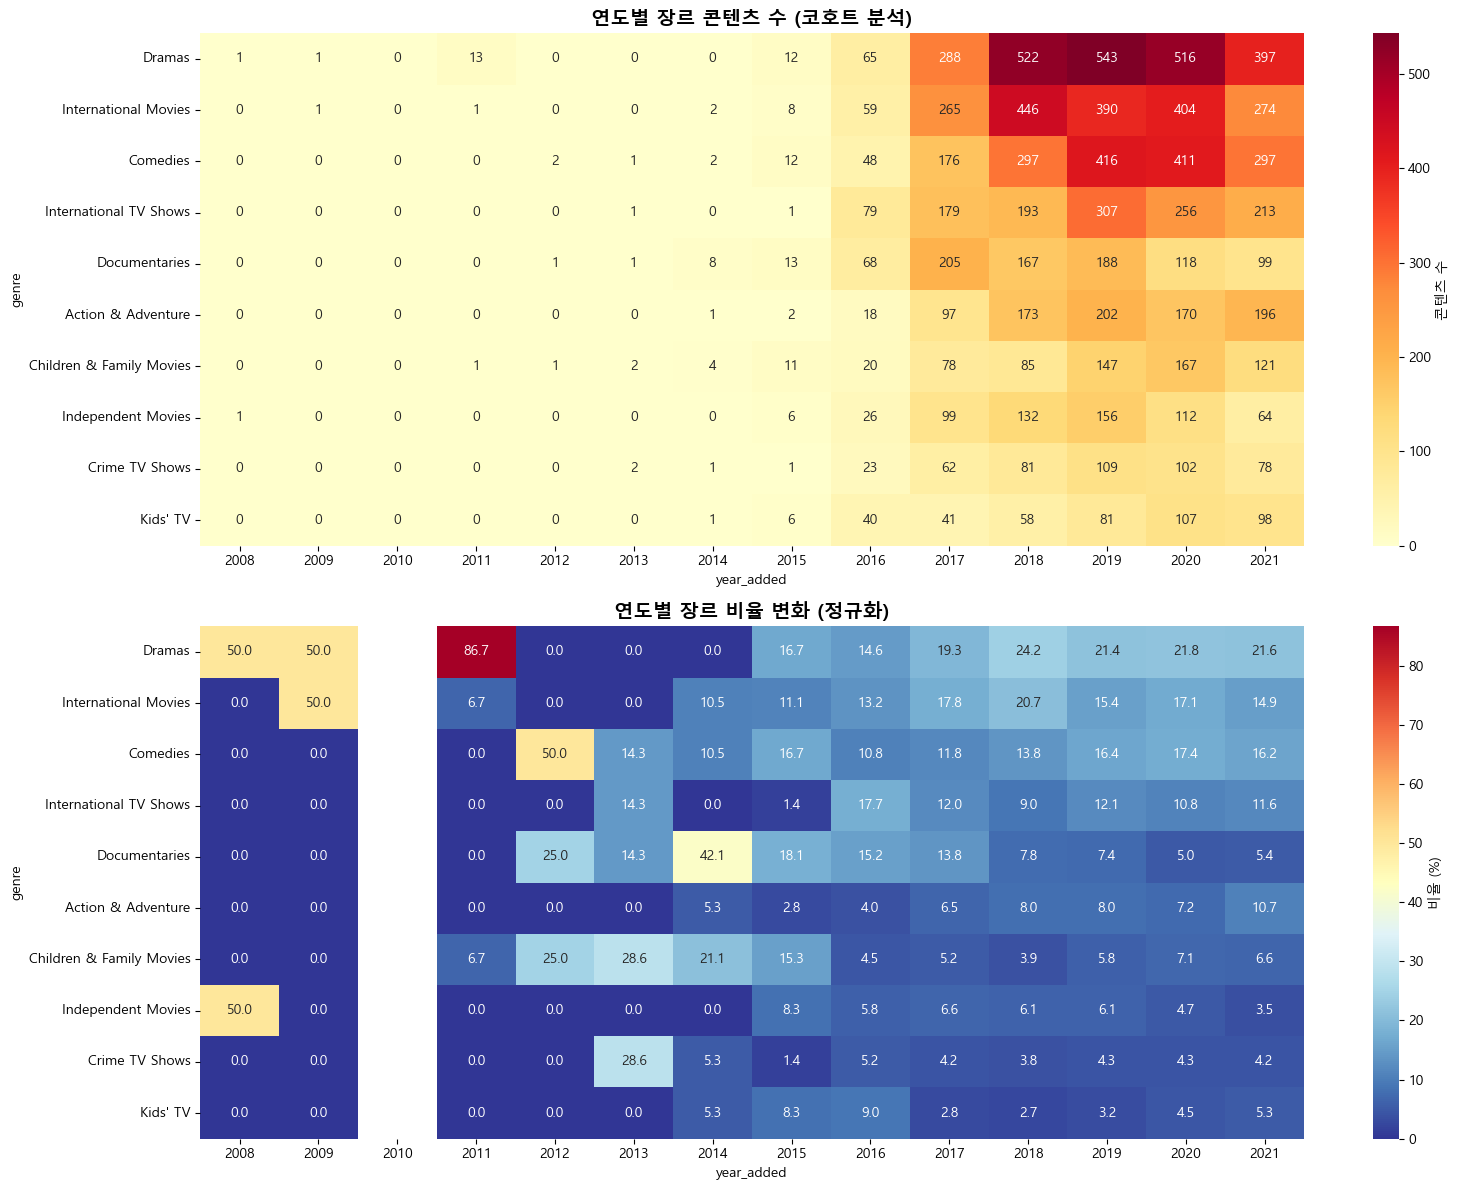

In [14]:
df_clean['year_added'] = df_clean['date_added'].dt.year

genre_data = []
for idx, row in df_clean.iterrows():
    if pd.notna(row['listed_in']):
        genres = [genre.strip() for genre in str(row['listed_in']).split(',')]
        for genre in genres[:2]:  # 상위 2개 장르만
            genre_data.append({'year_added': row['year_added'], 'genre': genre, 'type': row['type']})

genre_df = pd.DataFrame(genre_data)

cohort_table = genre_df.pivot_table(
    index='genre', columns='year_added', values='type', aggfunc='count', fill_value=0
)

top_genres = cohort_table.sum(axis=1).nlargest(10).index
cohort_table_top = cohort_table.loc[top_genres]
cohort_percentages = cohort_table_top.div(cohort_table_top.sum(axis=0), axis=1) * 100

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12))
sns.heatmap(cohort_table_top, annot=True, fmt='d', cmap='YlOrRd', ax=ax1, cbar_kws={'label': '콘텐츠 수'})
ax1.set_title('연도별 장르 콘텐츠 수 (코호트 분석)', fontsize=14, fontweight='bold')
sns.heatmap(cohort_percentages, annot=True, fmt='.1f', cmap='RdYlBu_r', ax=ax2, cbar_kws={'label': '비율 (%)'})
ax2.set_title('연도별 장르 비율 변화 (정규화)', fontsize=14, fontweight='bold')
plt.tight_layout()

# 장르 트렌드 계산
trend_analysis = {}
for genre in top_genres:
    percentages = cohort_percentages.loc[genre].values
    valid_mask = ~np.isnan(percentages)
    if np.sum(valid_mask) > 2:
        slope = np.polyfit(cohort_percentages.columns.values[valid_mask], percentages[valid_mask], 1)[0]
        trend_analysis[genre] = slope

print("코호트 분석")
print("장르 트렌드 (상승: +, 하락: -):", trend_analysis)


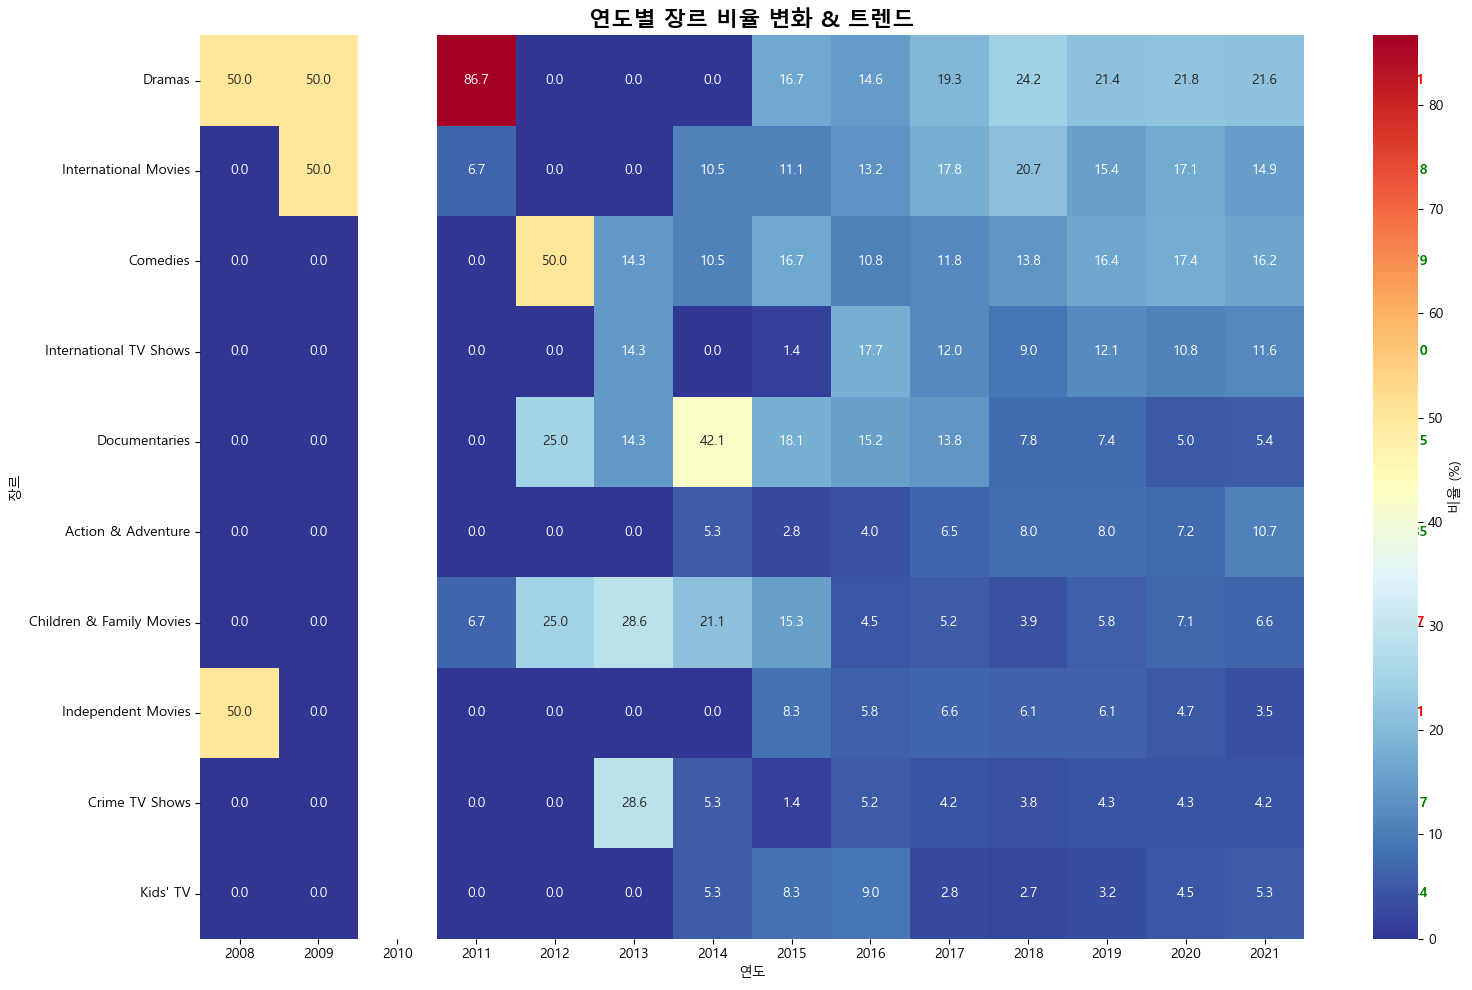

In [ ]:
plt.figure(figsize=(16, 10))
sns.heatmap(cohort_percentages, annot=True, fmt='.1f', cmap='RdYlBu_r', cbar_kws={'label': '비율 (%)'})

for i, genre in enumerate(top_genres):
    slope = trend_analysis.get(genre, 0)
    # 화살표 색상과 방향
    # 상승 = 초록, 하락 = 빨강
    color = 'green' if slope > 0 else 'red' if slope < 0 else 'gray'
    plt.arrow(
        x=len(cohort_percentages.columns) + 0.5,  # 히트맵 오른쪽 끝
        y=i + 0.5,
        dx=0.5, dy=0,  # 오른쪽으로 짧게 화살표
        head_width=0.3, head_length=0.2, fc=color, ec=color
    )
    plt.text(
        x=len(cohort_percentages.columns) + 1.1, 
        y=i + 0.5, 
        s=f"{slope:+.2f}", 
        va='center', color=color, fontweight='bold'
    )

plt.title('연도별 장르 비율 변화 & 트렌드', fontsize=16, fontweight='bold')
plt.xlabel('연도')
plt.ylabel('장르')
plt.tight_layout()
plt.show()

-----------------

# 대시보드 생성

In [17]:
def create_comprehensive_dashboard(df):
    if df is None or df.empty:
        print("유효한 데이터가 없습니다.")
        return None
    
    print(" Netflix 데이터 분석 대시보드")
    print("=" * 50)
    
    print(f"총 콘텐츠 수: {len(df):,}")
    print(f"영화: {len(df[df['type'] == 'Movie']):,} ({len(df[df['type'] == 'Movie'])/len(df)*100:.1f}%)")
    print(f"TV 프로그램: {len(df[df['type'] == 'TV Show']):,} ({len(df[df['type'] == 'TV Show'])/len(df)*100:.1f}%)")
    print(f"데이터 기간: {df['date_added'].min().strftime('%Y-%m-%d')} ~ {df['date_added'].max().strftime('%Y-%m-%d')}")
    print()
    
    dashboard_results = {}
    
    strategy_fig, yearly_content = analyze_content_strategy_shift(df)
    dashboard_results['strategy_analysis'] = strategy_fig
    
    global_fig, country_counts = analyze_global_content_distribution(df)
    dashboard_results['global_distribution'] = global_fig
    
    network_fig, top_degree, top_betweenness = create_actor_director_network(df)
    dashboard_results['network_analysis'] = network_fig
    
    similarity_fig, recommender, genre_dist = content_similarity_analysis(df)
    dashboard_results['similarity_analysis'] = similarity_fig
    dashboard_results['recommender'] = recommender
    
    growth_fig, monthly_data, future_predictions = growth_modeling_analysis(df)
    dashboard_results['growth_modeling'] = growth_fig


    insights = {
        'yearly_content': yearly_content,
        'country_counts': country_counts,
        'genre_distribution': genre_dist,
        'monthly_trends': monthly_data,
        'future_predictions': future_predictions
    }
    dashboard_results['insights'] = insights
    
    # 주요 인사이트 출력
    if yearly_content is not None:
        print(f" 최근 5년 TV 프로그램 비율 증가: {yearly_content['tv_ratio'].iloc[-1]:.1%}")
        print(f" 영화 대비 TV 프로그램 성장률: {((yearly_content['TV Show'].iloc[-1] / yearly_content['Movie'].iloc[-1]) - 1) * 100:.1f}%")
    
    if country_counts:
        top_3_countries = sorted(country_counts.items(), key=lambda x: x[1], reverse=True)[:3]
        print(f" 상위 3개국 콘텐츠 비율: {', '.join([f'{country}({count})' for country, count in top_3_countries])}")
    
    if genre_dist is not None:
        print(f" 가장 인기 장르: {genre_dist.index[0]} ({genre_dist.iloc[0]}개)")
    
    if monthly_data is not None:
       peak_month = monthly_data.loc[monthly_data['count'].idxmax()]
       print(f" 콘텐츠 추가 최고 월: {peak_month['year_added']}-{peak_month['month_added']:02d} ({peak_month['count']}개)")
    
    if future_predictions is not None:
        print(f" 향후 TV 프로그램 비율 예측: {future_predictions[-1]:.1%}")

    
    return dashboard_results


In [ ]:
def main():
    df = load_and_preprocess_netflix_data()
    
    if df is None:
        print("데이터를 불러올 수 없습니다. 프로그램을 종료합니다.")
        return
    
    dashboard = create_comprehensive_dashboard(df)
    
    if dashboard is None:
        print("대시보드 생성에 실패했습니다.")
        return
    

    analyses = [
        ('strategy_analysis', '콘텐츠 전략 분석'),
        ('global_distribution', '글로벌 콘텐츠 분포'),
        ('network_analysis', '배우-감독 네트워크'),
        ('similarity_analysis', '콘텐츠 유사도 분석'),
        ('growth_modeling', '성장 모델링')
    ]
        
    for key, name in analyses:
        if dashboard.get(key) is not None:
            print(f" {name}: 성공")
            item = dashboard[key]
            if isinstance(item, dict) and 'figure' in item:
                 item['figure'].show()
            else:
                 item.show()
        else:
            print(f" {name}: 실패")         
    
    # 추천 시스템 테스트
    if 'recommender' in dashboard:
        print("\n 추천 시스템 테스트:")
        print("=" * 30)
        
        if not df.empty:
            sample_title = df['title'].iloc[0]
            print(f"'{sample_title}'와 유사한 콘텐츠 추천:")
            recommendations = dashboard['recommender'](sample_title)
            if isinstance(recommendations, pd.DataFrame):
                print(recommendations.to_string(index=False))
            else:
                print(recommendations)
    
    print("\n Netflix 데이터 분석 완료")
    return dashboard


In [ ]:
def display_individual_charts(dashboard):
    if dashboard is None:
        print("표시할 대시보드가 없습니다.")
        return
    
    print("\n 개별 차트 표시")
    print("=" * 30)
    
    # 1. 콘텐츠 전략 분석
    if dashboard.get('strategy_analysis'):
        print("1️ 콘텐츠 전략 변화 분석")
        dashboard['strategy_analysis'].show()
        input("다음 차트를 보려면 Enter를 누르세요")
    
    # 2. 글로벌 분포
    if dashboard.get('global_distribution'):
        print("글로벌 콘텐츠 분포 분석")
        dashboard['global_distribution'].show()
        input("다음 차트를 보려면 Enter를 누르세요")
    
    # 3. 네트워크 분석
    if dashboard.get('network_analysis'):
        print(" 배우-감독 네트워크 분석")
        dashboard['network_analysis'].show()
        input("다음 차트를 보려면 Enter를 누르세요")
    
    # 4. 유사도 분석
    if dashboard.get('similarity_analysis'):
        print(" 콘텐츠 유사도 분석")
        dashboard['similarity_analysis'].show()
        input("다음 차트를 보려면 Enter를 누르세요")
    
    # 5. 성장 모델링
    if dashboard.get('growth_modeling'):
        print(" 성장 모델링 분석")
        dashboard['growth_modeling'].show()
        input("완료")



In [ ]:
def create_combined_html(chart_files, output_dir):
    try:
        combined_html = """
<!DOCTYPE html>
<html lang="ko">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Netflix 콘텐츠 분석 대시보드</title>
    <style>
        body {
            font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
            margin: 0;
            padding: 20px;
            background-color: #f5f5f5;
        }
        .header {
            text-align: center;
            background-color: #e50914;
            color: white;
            padding: 20px;
            border-radius: 10px;
            margin-bottom: 30px;
        }
        .nav {
            text-align: center;
            margin-bottom: 30px;
        }
        .nav a {
            display: inline-block;
            padding: 10px 20px;
            margin: 5px;
            background-color: #333;
            color: white;
            text-decoration: none;
            border-radius: 5px;
            transition: background-color 0.3s;
        }
        .nav a:hover {
            background-color: #e50914;
        }
        .chart-section {
            background-color: white;
            padding: 20px;
            margin-bottom: 20px;
            border-radius: 10px;
            box-shadow: 0 2px 5px rgba(0,0,0,0.1);
        }
        .chart-title {
            font-size: 24px;
            font-weight: bold;
            margin-bottom: 20px;
            color: #333;
            border-bottom: 2px solid #e50914;
            padding-bottom: 10px;
        }
        iframe {
            width: 100%;
            height: 800px;
            border: none;
            border-radius: 5px;
        }
        .footer {
            text-align: center;
            margin-top: 50px;
            padding: 20px;
            background-color: #333;
            color: white;
            border-radius: 10px;
        }
    </style>
</head>
<body>
    <div class="header">
        <h1> Netflix 콘텐츠 분석 대시보드</h1>
        <p>종합적인 Netflix 데이터 분석 및 시각화</p>
    </div>
    
    <div class="nav">
"""
        
        # 네비게이션 링크 생성
        for i, (_, filename) in enumerate(chart_files):
            combined_html += f'        <a href="#chart{i+1}">{filename.replace("_", " ")}</a>\n'
        
        combined_html += """    </div>
    
"""
        
        for i, (filepath, filename) in enumerate(chart_files):
            chart_filename = os.path.basename(filepath)
            combined_html += f"""    <div class="chart-section" id="chart{i+1}">
        <div class="chart-title">{i+1}. {filename.replace("_", " ")}</div>
        <iframe src="{chart_filename}"></iframe>
    </div>
    
"""
        
        combined_html += """    <div class="footer">
        <p>Generated by Netflix Analysis Dashboard</p>
        <p>© 2024 Netflix 콘텐츠 분석 프로젝트</p>
    </div>
</body>
</html>"""
        
        combined_filepath = os.path.join(output_dir, "netflix_dashboard.html")
        with open(combined_filepath, 'w', encoding='utf-8') as f:
            f.write(combined_html)
        
        print(f"✓ 통합 대시보드 생성 완료: {combined_filepath}")
        
    except Exception as e:
        print(f"✗ HTML 생성 실패: {e}")

In [ ]:
def save_charts_as_html(dashboard, output_dir='netflix_charts'):
    if dashboard is None:
        print("저장할 대시보드가 없습니다.")
        return
    
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    chart_files = []
    
    charts = [
        ('strategy_analysis', '콘텐츠_전략_분석'),
        ('global_distribution', '글로벌_콘텐츠_분포'),
        ('network_analysis', '배우_감독_네트워크'),
        ('similarity_analysis', '콘텐츠_유사도_분석'),
        ('growth_modeling', '성장_모델링')
    ]
    
    for key, filename in charts:
        if dashboard.get(key):
            filepath = os.path.join(output_dir, f"{filename}.html")
            dashboard[key].write_html(filepath)
            chart_files.append(filepath)
            print(f" {filename} 저장 완료: {filepath}")
    
    create_combined_html(chart_files, output_dir)
    
    print(f"\n 모든 차트가 '{output_dir}' 폴더에 저장되었습니다!")


In [ ]:

def export_analysis_report(dashboard, 
                           filename='netflix_analysis_report.txt'):
    if dashboard is None:
        print("내보낼 대시보드 데이터가 없습니다.")
        return
    
    try:
        with open(filename, 'w', encoding='utf-8') as f:
            f.write("Netflix 콘텐츠 분석 보고서\n")
            f.write("=" * 50 + "\n\n")
            
            insights = dashboard.get('insights', {})
            
            f.write(" 기본 통계\n")
            f.write("-" * 20 + "\n")
            
            if 'yearly_content' in insights:
                yearly_content = insights['yearly_content']
                f.write(f"연도별 콘텐츠 추가 현황:\n")
                f.write(yearly_content.to_string())
                f.write("\n\n")
            
            if 'country_counts' in insights:
                f.write(" 국가별 콘텐츠 분포\n")
                f.write("-" * 20 + "\n")
                country_counts = insights['country_counts']
                top_10 = sorted(country_counts.items(), key=lambda x: x[1], reverse=True)[:10]
                for country, count in top_10:
                    f.write(f"{country}: {count}\n")
                f.write("\n")
            
            if 'genre_distribution' in insights:
                f.write(" 장르별 콘텐츠 분포\n")
                f.write("-" * 20 + "\n")
                genre_dist = insights['genre_distribution']
                f.write(genre_dist.to_string())
                f.write("\n\n")
            
            if 'future_predictions' in insights:
                f.write(" 미래 예측\n")
                f.write("-" * 20 + "\n")
                future_predictions = insights['future_predictions']
                f.write(f"향후 TV 프로그램 비율 예측: {future_predictions}\n")
                f.write("\n")
            
            f.write("분석 완료 시간: " + datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

        
        print(f" 분석 보고서가 '{filename}'에 저장되었습니다.")
        
    except Exception as e:
        print(f"보고서 저장 중 오류 발생: {e}")


In [ ]:
def interactive_recommendation_system(dashboard):
    if dashboard is None or 'recommender' not in dashboard:
        print("추천 시스템을 사용할 수 없습니다.")
        return
    
    print("\n Netflix 콘텐츠 추천 시스템")
    print("=" * 40)
    print("종료하려면 'quit'를 입력하세요.")
    
    while True:
        try:
            user_input = input("\n추천받고 싶은 콘텐츠 제목을 입력하세요: ").strip()
            
            if user_input.lower() in ['quit', 'exit', '종료']:
                print("추천 시스템을 종료합니다.")
                break
            
            if not user_input:
                print("제목을 입력해주세요.")
                continue
            
            print(f"\n'{user_input}'와 유사한 콘텐츠를 찾는 중...")
            recommendations = dashboard['recommender'](user_input)
            
            if isinstance(recommendations, pd.DataFrame):
                print("\n 추천 결과:")
                print("-" * 30)
                for idx, row in recommendations.iterrows():
                    print(f"{idx+1}. {row['title']} ({row['type']})")
                    print(f"   장르: {row['extracted_genre']}, 등급: {row['rating']}")
                    print(f"   유사도: {row['similarity_score']:.3f}")
                    print()
            else:
                print(f" {recommendations}")
                
        except KeyboardInterrupt:
            print("\n추천 시스템을 종료합니다.")
            break
        except Exception as e:
            print(f"오류 발생: {e}")

In [ ]:
if __name__ == "__main__":
    dashboard = main()
    
    if dashboard:
        export_analysis_report(dashboard)
        save_charts_as_html(dashboard)
        user_choice = input("\n개별 차트를 순차적으로 보시겠습니까? (y/n): ").lower()
        if user_choice == 'y':
            display_individual_charts(dashboard)
        
        user_choice = input("\n추천 시스템을 사용하시겠습니까? (y/n): ").lower()
        if user_choice == 'y':
            interactive_recommendation_system(dashboard)

Original data shape: (8807, 12)
날짜 없는 행 98개 제거
Preprocessing complete. Final data shape: (8709, 17)
 Netflix 데이터 분석 대시보드
총 콘텐츠 수: 8,709
영화: 6,131 (70.4%)
TV 프로그램: 2,578 (29.6%)
데이터 기간: 2008-01-01 ~ 2021-09-25

 최근 5년 TV 프로그램 비율 증가: 33.7%
 영화 대비 TV 프로그램 성장률: -49.1%
 상위 3개국 콘텐츠 비율: United States(3642), India(1045), United Kingdom(785)
 가장 인기 장르: 기타 (3962개)
 콘텐츠 추가 최고 월: 2021-07 (257개)
 향후 TV 프로그램 비율 예측: 38.8%

분석 완료!
 콘텐츠 전략 분석: 성공


 글로벌 콘텐츠 분포: 성공


 배우-감독 네트워크: 성공


 콘텐츠 유사도 분석: 성공


 성장 모델링: 성공



 추천 시스템 테스트:
'Dick Johnson Is Dead'와 유사한 콘텐츠 추천:
               title  type extracted_genre rating  similarity_score
            Extremis Movie             드라마  TV-PG          0.421492
    Black Snake Moan Movie              기타      R          0.403071
            The Soul Movie             드라마  TV-MA          0.338838
      Can’t Complain Movie              기타  TV-MA          0.324404
Brij Mohan Amar Rahe Movie             드라마  TV-MA          0.310751

 Netflix 데이터 분석 완료!

 모든 차트 표시 중...
 분석 보고서가 'netflix_analysis_report.txt'에 저장되었습니다.
 콘텐츠_전략_분석 저장 완료: netflix_charts\콘텐츠_전략_분석.html
 글로벌_콘텐츠_분포 저장 완료: netflix_charts\글로벌_콘텐츠_분포.html
 배우_감독_네트워크 저장 완료: netflix_charts\배우_감독_네트워크.html
 콘텐츠_유사도_분석 저장 완료: netflix_charts\콘텐츠_유사도_분석.html
 성장_모델링 저장 완료: netflix_charts\성장_모델링.html
✗ 통합 HTML 생성 실패: too many values to unpack (expected 2)

 모든 차트가 'netflix_charts' 폴더에 저장되었습니다!
